In [1]:
# 1. Imports & helpers
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
plt.rcParams['figure.figsize'] = (12,5)
sns.set(style="whitegrid")


In [6]:
# 2. Load CSV (robust timestamp parsing)
data_path = r"C:\Users\Devra\Wind_energy_prediction\Data\T1.csv"
df = pd.read_csv(data_path)

# try to find a timestamp column automatically
time_cols = [c for c in df.columns if 'time' in c.lower() or 'date' in c.lower() or 'timestamp' in c.lower()]
print("Candidate time columns:", time_cols)
# prefer explicit names if present
ts_col = time_cols[0] if time_cols else df.columns[0]
print("Using timestamp column:", ts_col)

# parse and set index
df[ts_col] = pd.to_datetime(df[ts_col], errors='coerce')
df = df.set_index(ts_col).sort_index()
df.index.name = 'timestamp'
df.head()


Candidate time columns: ['Date/Time']
Using timestamp column: Date/Time


,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
timestamp,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [7]:
# 3. Quick info & missing values
display(df.head())
print(df.info())
print("\nMissing values per column:\n", df.isna().sum())
print("\nSummary stats:\n", df.describe())


,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
timestamp,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50530 entries, 2018-01-01 00:00:00 to NaT
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   LV ActivePower (kW)            50530 non-null  float64
 1   Wind Speed (m/s)               50530 non-null  float64
 2   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 3   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4)
memory usage: 1.9 MB
None

Missing values per column:
 LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

Summary stats:
        LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  \
count         50530.000000      50530.000000                   50530.000000   
mean           1307.684332          7.557952                    1492.175463   
std            1312.459242      

In [8]:
# 4. Choose a target column (wind speed or power). Adjust name if different.
possible_targets = ['power','power_output','wind_power','wind_speed','windspeed','ws','WS']
target = None
for cand in possible_targets:
    for col in df.columns:
        if cand.lower() == col.lower():
            target = col
            break
    if target:
        break
print("Target selected:", target)
# if None, pick numeric column with most non-null values
if target is None:
    numeric_cols = df.select_dtypes('number').columns.tolist()
    # pick the numeric column with fewest nulls
    target = min(numeric_cols, key=lambda c: df[c].isna().sum())
    print("Fallback target:", target)


Target selected: None
Fallback target: LV ActivePower (kW)


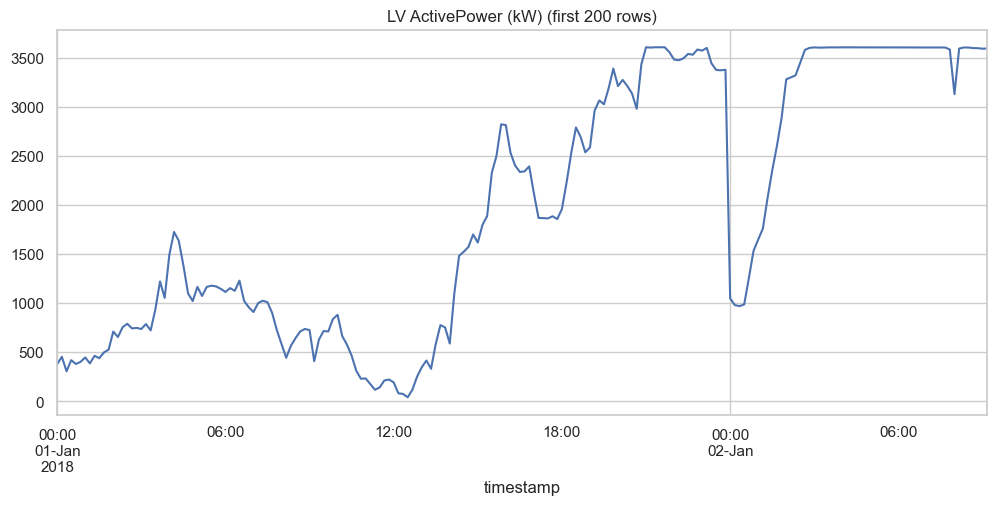

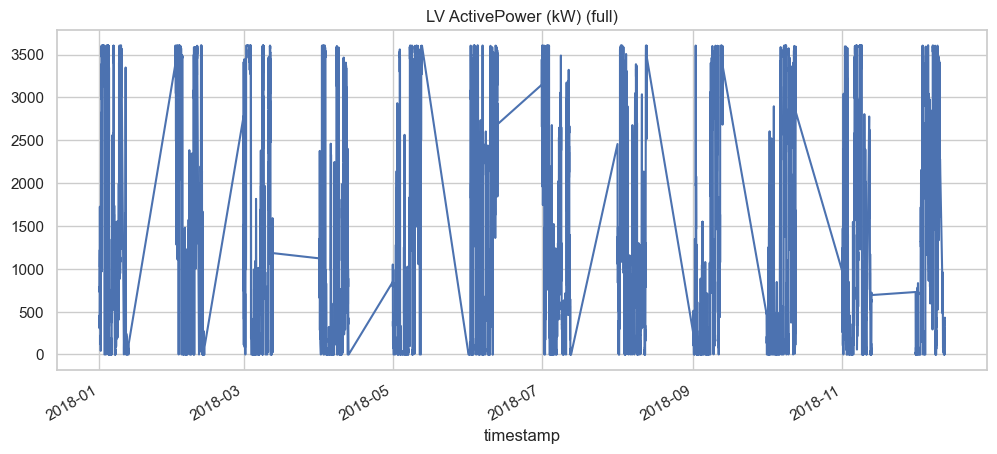

In [9]:
# 5. Visualize a sample and long-term
df[target].head(200).plot(title=f"{target} (first 200 rows)")
plt.show()

df[target].plot(title=f"{target} (full)")
plt.show()


In [10]:
# 6. Resample / fill small gaps: make hourly series (change 'H' if you want 10T)
hourly = df.resample("H").mean()   # mean aggregation
print("Original rows:", len(df), "Hourly rows:", len(hourly))

# Count missing timestamps
missing = hourly[target].isna().sum()
print(f"Missing values in {target} after resample:", missing)

# Interpolate small gaps (time-based) and forward/backfill for leading/trailing
hourly[target] = hourly[target].interpolate(method='time', limit=6)   # limit 6 hours
hourly[target] = hourly[target].fillna(method='ffill').fillna(method='bfill')

# Show after imputation
print("Missing now:", hourly[target].isna().sum())
hourly[[target]].describe()


Original rows: 50530 Hourly rows: 8304
Missing values in LV ActivePower (kW) after resample: 4965
Missing now: 0


C:\Users\Devra\AppData\Local\Temp\ipykernel_15052\2351999344.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = df.resample("H").mean()   # mean aggregation
C:\Users\Devra\AppData\Local\Temp\ipykernel_15052\2351999344.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly[target] = hourly[target].fillna(method='ffill').fillna(method='bfill')


,LV ActivePower (kW)
count,8304.000000
mean,1470.551852
std,1422.883807
min,-0.065511
25%,90.109927
50%,658.406025
75%,3137.844497
max,3604.410034


In [11]:
# 7. Outlier removal (IQR) - mark then interpolate
q1 = hourly[target].quantile(0.25)
q3 = hourly[target].quantile(0.75)
iqr = q3 - q1
low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
print("Outlier thresholds:", low, high)
mask = (hourly[target] < low) | (hourly[target] > high)
print("Outliers found:", mask.sum())
hourly.loc[mask, target] = np.nan
hourly[target] = hourly[target].interpolate(method='time').fillna(method='ffill').fillna(method='bfill')


Outlier thresholds: -4481.491928280398 7709.446352135426
Outliers found: 0


C:\Users\Devra\AppData\Local\Temp\ipykernel_15052\76350988.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly[target] = hourly[target].interpolate(method='time').fillna(method='ffill').fillna(method='bfill')


In [12]:
# 8. Feature engineering (time features, lags, rolling)
df_feat = hourly.copy()
df_feat['hour'] = df_feat.index.hour
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['month'] = df_feat.index.month
# cyclic hour
df_feat['hour_sin'] = np.sin(2*np.pi*df_feat['hour']/24)
df_feat['hour_cos'] = np.cos(2*np.pi*df_feat['hour']/24)
# Lags and rolling
for lag in [1, 24, 168]:
    df_feat[f'lag_{lag}'] = df_feat[target].shift(lag)
for w in [3, 24, 168]:
    df_feat[f'roll_mean_{w}'] = df_feat[target].rolling(w).mean()
    df_feat[f'roll_std_{w}'] = df_feat[target].rolling(w).std()

# drop initial NA rows resulting from shifts
df_feat = df_feat.dropna()
print("Rows after feature creation:", len(df_feat))
display(df_feat.head())


Rows after feature creation: 3171


,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),hour,dayofweek,month,hour_sin,hour_cos,lag_1,lag_24,lag_168,roll_mean_3,roll_std_3,roll_mean_24,roll_std_24,roll_mean_168,roll_std_168
timestamp,,,,,,,,,,,,,,,,,,
2018-01-08 00:00:00,1089.056173,7.680821,1354.600143,69.493165,0,0,1,0.000000,1.000000,495.646784,1441.629985,390.480362,670.860074,363.750134,384.843033,426.994359,1566.127084,1471.540291
2018-01-08 01:00:00,1133.227468,7.795088,1419.917458,68.601665,1,0,1,0.258819,0.965926,1089.056173,1518.077840,460.537125,905.976808,356.041883,368.807601,388.035358,1570.131193,1469.427620
2018-01-08 02:00:00,1106.057658,7.786456,1411.369715,63.571226,2,0,1,0.500000,0.866025,1133.227468,1108.060364,733.655375,1109.447099,22.279858,368.724155,387.869652,1572.347874,1468.438771
2018-01-08 03:00:00,938.984985,7.298144,1160.437617,52.410904,3,0,1,0.707107,0.707107,1106.057658,816.730764,909.362081,1059.423370,105.183664,373.818081,394.750922,1572.524200,1468.360460
2018-01-08 04:00:00,649.472880,6.398343,795.254428,47.624413,4,0,1,0.866025,0.500000,938.984985,719.046616,1393.518188,898.171841,231.012336,370.919175,392.353646,1568.095359,1470.024753


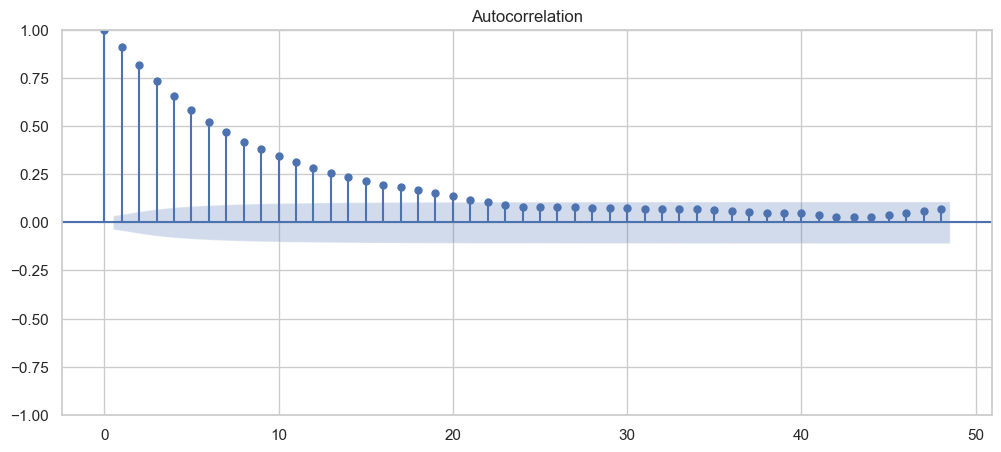

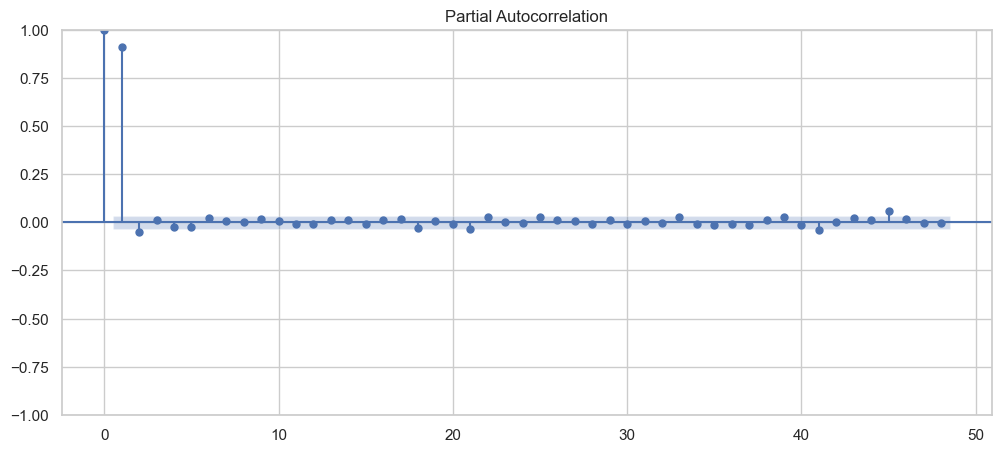

ADF Statistic: -12.681769790252652
p-value: 1.182743402978518e-23
Test Statistic -12.681769790252652
p-value 1.182743402978518e-23
#Lags used 1
#Observations 3169


In [13]:
# 9. ACF/PACF and stationarity test (for ARIMA)
plot_acf(df_feat[target].dropna(), lags=48); plt.show()
plot_pacf(df_feat[target].dropna(), lags=48); plt.show()

adf_result = adfuller(df_feat[target].dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for k,v in zip(['Test Statistic','p-value','#Lags used','#Observations'], adf_result[:4]):
    print(k, v)


In [14]:
# 10. Save processed for modeling
processed_path = r"C:\Users\Devra\Wind_energy_prediction\Results\Resultsprocessed_hourly.csv"
os.makedirs(r"C:\Users\Devra\Wind_energy_prediction\Results", exist_ok=True)
df_feat.to_csv(processed_path, index=False)
print("✅ Saved processed dataset to", processed_path)



✅ Saved processed dataset to C:\Users\Devra\Wind_energy_prediction\Results\Resultsprocessed_hourly.csv


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed hourly dataset
df_hourly = pd.read_csv(
    r"C:\Users\Devra\Wind_energy_prediction\Results\processed_hourly.csv",
    parse_dates=['Date/Time'],
    index_col='Date/Time'
)

print(df_hourly.head())
print("\nShape:", df_hourly.shape)


                     ActivePower_kW  WindSpeed_mps  TheoreticalPowerCurve_kWh  \
Date/Time                                                                       
2018-01-01 00:00:00      390.480362       5.506868                 472.402227   
2018-01-01 01:00:00      460.537125       5.644205                 513.418408   
2018-01-01 02:00:00      733.655375       6.452037                 788.401310   
2018-01-01 03:00:00      909.362081       6.811455                 948.793346   
2018-01-01 04:00:00     1393.518188       7.748749                1406.391795   

                     WindDirection_deg  
Date/Time                               
2018-01-01 00:00:00         267.118632  
2018-01-01 01:00:00         258.945546  
2018-01-01 02:00:00         268.397466  
2018-01-01 03:00:00         256.014765  
2018-01-01 04:00:00         247.652468  

Shape: (8760, 4)


In [2]:
# Display descriptive stats
print(df_hourly.describe())

# Correlation between variables
corr = df_hourly.corr()
print("\nCorrelation matrix:\n", corr)


       ActivePower_kW  WindSpeed_mps  TheoreticalPowerCurve_kWh  \
count     8760.000000    8760.000000                8760.000000   
mean      1267.603333       7.497724                1484.613696   
std       1285.084633       4.154700                1342.839130   
min         -0.179522       0.000000                   0.000000   
25%         53.725890       4.098363                 170.748201   
50%        786.112216       7.068810                1084.437536   
75%       2363.534398      10.236294                2879.351697   
max       3604.410034      23.746877                3600.000000   

       WindDirection_deg  
count        8760.000000  
mean          122.417494  
std            87.708586  
min             0.000000  
25%            51.198138  
50%            75.517254  
75%           199.790272  
max           357.265218  

Correlation matrix:
                            ActivePower_kW  WindSpeed_mps  \
ActivePower_kW                   1.000000       0.910095   
WindSpeed_m

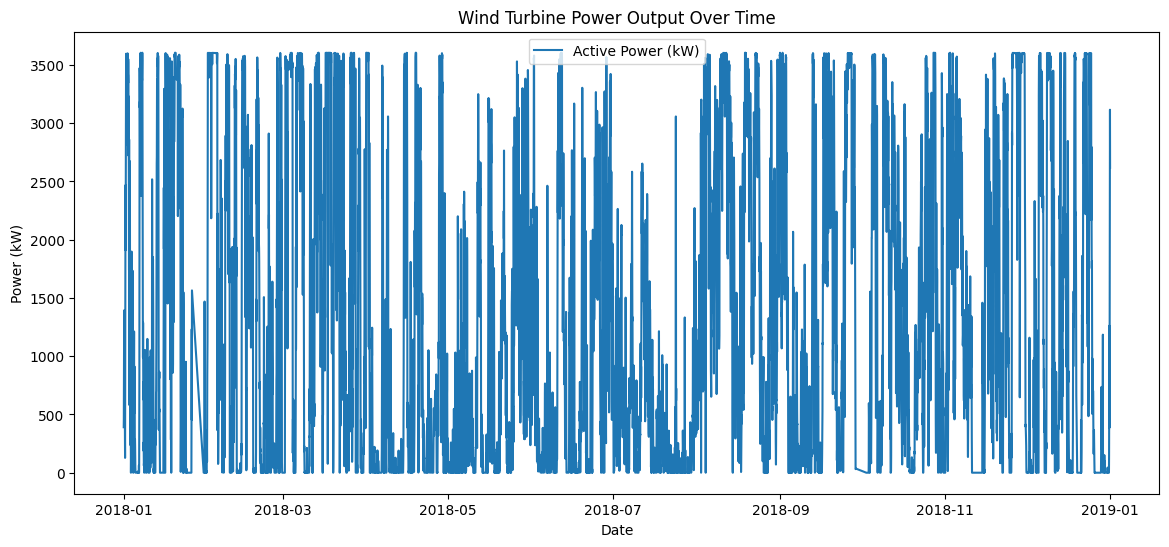

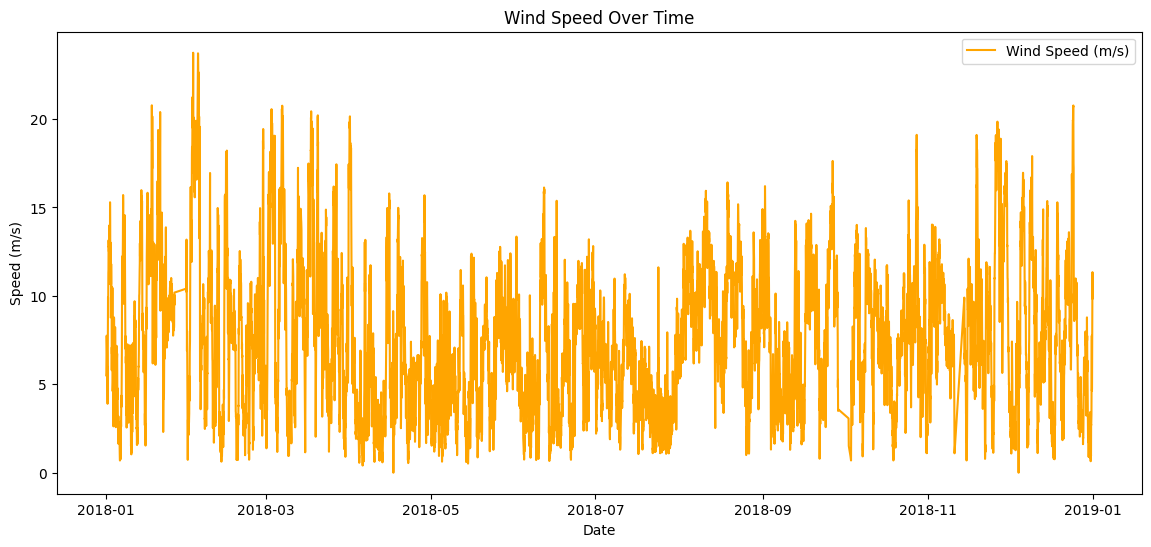

In [3]:
plt.figure(figsize=(14,6))
plt.plot(df_hourly['ActivePower_kW'], label='Active Power (kW)')
plt.title('Wind Turbine Power Output Over Time')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
plt.plot(df_hourly['WindSpeed_mps'], color='orange', label='Wind Speed (m/s)')
plt.title('Wind Speed Over Time')
plt.xlabel('Date')
plt.ylabel('Speed (m/s)')
plt.legend()
plt.show()


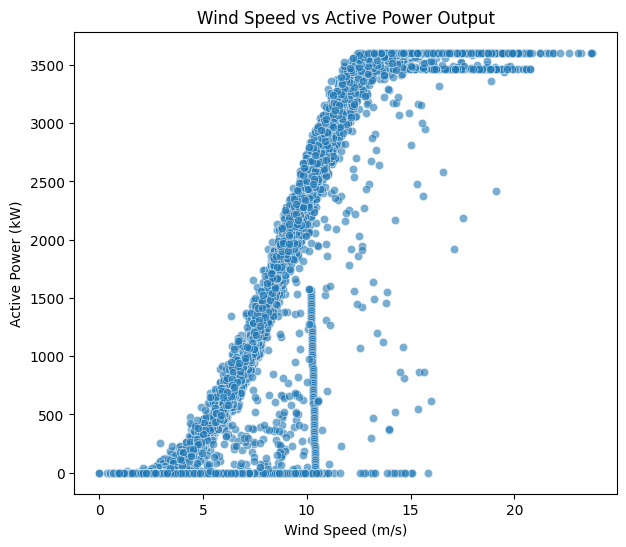

In [4]:
plt.figure(figsize=(7,6))
sns.scatterplot(x='WindSpeed_mps', y='ActivePower_kW', data=df_hourly, alpha=0.6)
plt.title('Wind Speed vs Active Power Output')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Active Power (kW)')
plt.show()


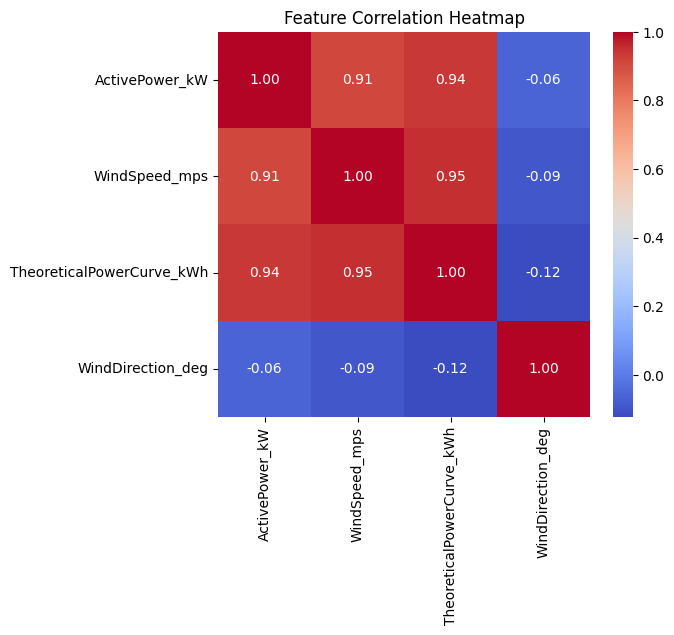

In [5]:
plt.figure(figsize=(6,5))
sns.heatmap(df_hourly.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()


C:\Users\Devra\AppData\Local\Temp\ipykernel_12268\2607140956.py:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(df_hourly['ActivePower_kW'], alpha=0.4, label='Actual Power')


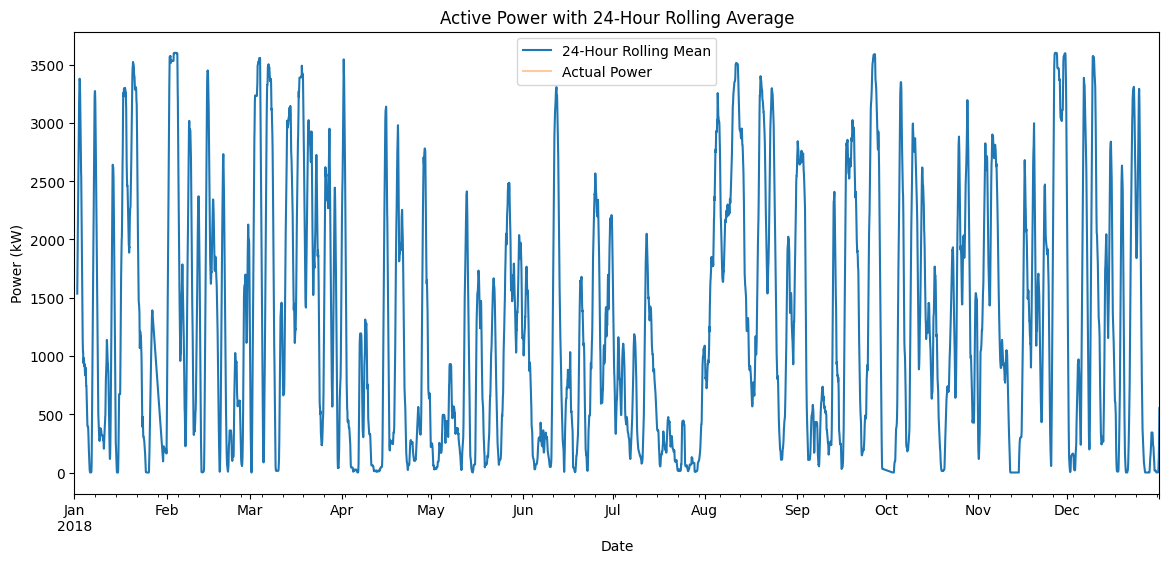

In [6]:
plt.figure(figsize=(14,6))
df_hourly['ActivePower_kW'].rolling(window=24).mean().plot(label='24-Hour Rolling Mean')
plt.plot(df_hourly['ActivePower_kW'], alpha=0.4, label='Actual Power')
plt.title('Active Power with 24-Hour Rolling Average')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()
